# Small-time asymptotics for the mass at zero in SABR
***
Reference: 
A. Gulisashvili, B. Horvath, A. Jacquier.
Mass at zero in the uncorrelated SABR model. 
Quantitative Finance, 18(10): 1753-1765, 2018.
https://www.tandfonline.com/doi/full/10.1080/14697688.2018.1432883

In [8]:
import numpy as np
from scipy.special import gamma, gammainc, hyp1f1
from scipy.integrate import quad
from scipy.optimize import bisect
import pandas as pd
import matplotlib.pylab as plt
from time import time

The stochastic alpha, beta, rho (SABR) model is defined by the pair of coupled stochastic differential equations
\begin{equation}\label{SABRdynamicsOriginal}
\begin{array}{rll}
\mathrm{d} X_t & = Y_t X_t^{\beta}\mathrm{d}W_t, \qquad & X_0 = x_0,\\
\mathrm{d} Y_t & = \nu Y_t \mathrm{d}Z_t, \qquad & Y_0 = y_0,\\
\mathrm{d} \langle Z,W\rangle_t & = \rho \mathrm{d}t,
\end{array}
\end{equation}
with $\beta<1$, $\nu>0$ and $\rho \in (-1, 1)$.
Let us now assume that the correlation $\rho$ is null.
Then, for any time $t\geq 0$, the mass at zero has the following expression:
$$
\mathbb{P}\left(X_{t}=0\right)
=\int_0^{\infty} \mathbb{P} \left(\widetilde{X}_{r}=0\right) \mathbb{P}\left(\int_0^t Y_s^2 \mathrm{d}s\in \mathrm{d}r\right)\mathrm{d}r,
$$
where
$$
\mathbb{P}\left(\widetilde{X}_{r}=0\right) = 1-\Gamma \left(-\frac{1}{2(1-\beta)},\frac{x_0^{2(1-\beta)}}{2r(1-\beta)^2}\right), 
$$
and $\Gamma$ is the normalized lower incomplete Gamma function
$\Gamma(v,z) \equiv \Gamma(v)^{-1}\int_0^zu^{v-1}\mathrm{e}^{-u} \mathrm{d}u$,
and
$$
\mathbb{P}\left(\int_0^t Y_s^2 \mathrm{d}s\in \mathrm{d}r\right)
=\mathbb{P}\left(\int_0^{t} \mathrm{e}^{2\nu Z^{(-\nu/2)}_s} \mathrm{d}s \in \mathrm{d}\widetilde{r}\right),
$$
where $\widetilde{r}:=r/y_0^2$ and $Z^{(-\nu/2)}_s:= Z_s -\frac{\nu s}{2}$.
In Borodin-Salminen\cite{Borodin}{exp}, the density of the above functional is given by
$$
\mathbb{P}\left(\int_0^{t} e^{2\nu Z^{(-\nu/2)}_s} \mathrm{d}s \in \mathrm{d}\widetilde{r}\right)
 = \frac{2^{1/4}\sqrt{\nu}}{\widetilde{r}^{3/4}}
\exp\left(-\frac{\nu^2 t}{8}-\frac{1}{4\nu^2 \widetilde{r}}\right)
m_{2 \nu^2 t}
\left(-\frac{3}{4}, \frac{1}{4 \nu^2 \widetilde{r}}\right)\mathrm{d}\widetilde{r},
$$
where the function $m$ is defined as
$$
m_y(\mu,z) \equiv 
\frac{8 z^{3/2} \Gamma(\mu+\frac{3}{2})\mathrm{e}^{\frac{\pi ^2}{4y}}}{\pi \sqrt{2 \pi y}} 
\int_0^{\infty} \exp\left(-z \cosh (2u) - \frac{1}{y}u^2\right) \mathrm{M}\left(-\mu,\frac{3}{2}, 2 z \sinh (u)^2\right) 
\sinh(2u)\sin\left(\frac{\pi u}{y}\right) \mathrm{d}u,
$$
where $\mathrm{M}$ is the Kummer function.

# Computations by integration (quadrature)

In [9]:
################################################################
###Computes the function m by direct integration (quadrature)###
################################################################
def integrand_m(y, z, u):
    temp = np.exp(-z*np.cosh(2.*u))*hyp1f1(0.75, 1.5, 2.*z*np.sinh(u)*np.sinh(u))*np.sin(np.pi*u/y)
    return np.exp(-u*u/y)*temp*np.sinh(2.*u)

def m(y, z):
    mu = -3./4.
    c = 8. * z*np.sqrt(z/y)*gamma(mu+1.5)*np.exp(0.25*np.pi*np.pi/y)/(np.pi*np.sqrt(2.*np.pi))
    return c*quad(lambda u: integrand_m(y, z, u), 0., 2., epsrel=1.49e-10, limit=200)[0]

################################################################
################################################################

################################################################
###Computes the mass by direct integration of the function m)###
################################################################
def pp(r, T, nu):
    return 2.**(0.25)*np.sqrt(nu)/(r**(3./4.))*np.exp(-nu*nu*T/8. - 0.25/(nu*nu*r))*m(2.*nu*nu*T, 1./(4.*nu*nu*r))

def ppX(r, beta, x0):
    ## mass at zero in the CEV model
    b1 = 1.-beta
    return 1. - gammainc(0.5/b1, 0.5*x0**(2.*b1)/(r*b1*b1))
################################################################
################################################################

In [10]:
def mass_0_SmallTime(T, y0, nu, beta, x0, rMax=2.):
    return quad(lambda r: pp(r/(y0*y0), T, nu)*ppX(r, beta, x0),0.,rMax)[0]/(y0*y0)

def mass_0_SmallTimeQ(T, y0, nu, beta, x0, rMax=2., eps=1E-4): ## faster!!!!!!!!!!!!!!!
    return quad(lambda r: pp(r/(y0*y0), T, nu)*ppX(r, beta, x0),0.,rMax, epsabs=eps)[0]/(y0*y0)

#### Checking numerical convergence of the integrands (to determine an optimal upper bound for integration)

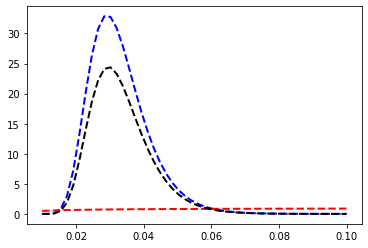

In [11]:
nu, beta, x0, y0, T = 1., 0.3, 0.02, 0.8, 0.05
rr = np.linspace(0.01, 0.1, 50)
inte1 = [pp(r/(y0*y0), T, nu) for r in rr]
inte2 = [ppX(r, beta, x0) for r in rr]
plt.plot(rr, inte1, 'b--', linewidth=2, label="int1")
plt.plot(rr, inte2, 'r--', linewidth=2, label="int2")
plt.plot(rr, [ i1*i2 for (i1,i2) in zip(inte1, inte2)], 'k--', linewidth=2, label="int")
plt.show()

## Small-time approximations

In [12]:
def approx_m(y,z):
    mu = -3. / 4.
    ## Small-time expansion for the function m
    def sol(u, *args):
        y = args[0]
        z = args[1]
        return (2.*mu - 1. + 4.*u*y + 2.*np.log(z/2.)*np.sqrt(u) - np.sqrt(u)*np.log(u))
    uy = bisect(sol, 1E-4, 1E7, args=(y, z), xtol=1e-20, rtol=1e-12, full_output=False, disp=True)
    ee = (0.5-mu)*(1.-0.5*np.log(uy))-y*uy+np.sqrt(uy)
    My = np.log(uy) / (16. *uy*np.sqrt(uy)) - (1. + np.log(z/2.))/(8. *uy*np.sqrt(uy)) + (1.-2.*mu)/(8.*uy*uy)
    return 0.5*np.sqrt(z/np.pi)*np.exp(ee)/np.sqrt(My)

def approx_Integral_m_Bootstrap(y, z):
    ## Small-time approximation of the function m using the bootstrap expansion for the constant M_y
    mu = -3./ 4.
    def sol(u, *args):
        y = args[0]
        z = args[1]
        return (2.*mu - 1.+4.*u*y +2.*np.log(z/2.)*np.sqrt(u) - np.sqrt(u)*np.log(u))
    uy = bisect(sol, 1E-3, 1E6, args=(y, z), xtol=1e-20, rtol=1e-13, full_output=False, disp=True)
    ee = (0.5-mu)*(1.-0.5*np.log(uy))-y*uy+np.sqrt(uy)
    return 0.5*np.sqrt(z/np.pi)*abs(np.log(y))/(y*np.sqrt(y))*np.exp(ee)

def approx_m_2Terms(y, z):
    ## Small-time expansion for the function m, with only two terms for the constant M_y
    mu = -3./ 4.
    def sol(u, *args):
        y = args[0]
        z = args[1]
        return (2.*mu - 1. + 4.*u*y +2.*np.log(z/2.)*np.sqrt(u) - np.sqrt(u)*np.log(u))
    uy = bisect(sol, 1E-3, 1E6, args=(y, z), xtol=1e-20, rtol=1e-12, full_output=False, disp=True)
    ee = (0.5-mu)*(1.-0.5*np.log(uy))-y*uy+np.sqrt(uy)
    My = np.log(uy) / (16. *uy*np.sqrt(uy)) - (1. + np.log(z/2.))/(8. *uy*np.sqrt(uy)) #+ (1.0-2.0*mu)/(8.0*uy*uy)
    return 0.5*np.sqrt(z/np.pi)*np.exp(ee)/np.sqrt(My)

### Using the small-time approximation of the function $m$

In [13]:
def pp_approx(r, T, nu):
    return 2.**(0.25)*np.sqrt(nu)/(r**(3./4.))*np.exp(-nu*nu*T/8. - 0.25/(nu*nu*r))*approx_m(2.*nu*nu*T, 1./(4.*nu*nu*r))

In [14]:
def mass_0_SmallTime_approx(T, y0, nu, beta, x0, rMax=2.):
    return quad(lambda r: pp_approx(r/(y0*y0), T, nu)*ppX(r,beta,x0),0.,rMax, epsrel=1.49e-6, limit=50)[0]/(y0*y0)

## Mass using approximations of $I_t := \int_{0}^{t}Y_s^2 \mathrm{d}s$

### $I_t \approx y_0^2 t$

In that case, following the notations in the paper, we have
$$
\mathbb{P}(X_t=0) = \mathbb{P}\left(\widetilde{X}_{I_t}=0\right) \approx \mathbb{P}\left(\widetilde{X}_{y_0^2 t}=0\right).
$$

In [15]:
def mass_0_SmallTime_approx1(T, y0, nu, beta, x0):
    return ppX(y0*y0*T,beta,x0)
TT = np.linspace(0.05, .2, 10)

### Matching moments

Assume that 
$I_t =: y_0^2 J_t \approx y_0^2\Theta$,
where $\Theta$ is a log-Normal random variable. 
Writing $\Theta = \exp(\mu + \sigma \mathcal{N}(0,1))$, we have
$$
\mathbb{E}(\Theta) = \exp\left(\mu+\frac{\sigma^2}{2}\right)
\qquad\text{and}\qquad
\mathbb{E}(\Theta^2) = \exp\left(2\mu+2\sigma^2\right).
$$
We can further compute the first two moment of $J_t$ as 
$$
\mathbb{E}(J_t) = \frac{1}{\nu^2}\left(\mathrm{e}^{\nu^2 t}-1\right)
\qquad\text{and}\qquad
\mathbb{E}(J_t^2) = \frac{1}{15\nu^4}\left(\mathrm{e}^{6\nu^2 t} - 6\mathrm{e}^{\nu^2 t} + 5\right).
$$
Matching the moments, we obtain
$$
\mu = \log\left(\frac{\mathbb{E}(J_t)^2}{\sqrt{\mathbb{E}(J_t^2)}}\right)
\qquad\text{and}\qquad
\sigma^2 = \log\left(\frac{\mathbb{E}(J_t^2)}{\mathbb{E}(J_t)^{2}}\right).
$$
Therefore, the density of $I_t$ is approximated as
$f_{I_t}(z) \approx y_0^{-2}f_{\Theta}\left(\frac{z}{y_0^2}\right)$,
with
$$
f_{\Theta}(z) = \frac{1}{z\sigma\sqrt{2\pi}}\exp\left\{-\frac{(\log(z)-\mu)^2}{2\sigma^2}\right\}.
$$

In [16]:
def logNormalDensity(mu, sigma, z):
    return np.exp(-(np.log(z)-mu)*(np.log(z)-mu) / (2.*sigma*sigma))/(z*sigma*np.sqrt(2.*np.pi))

def densityLNMatched(T, y0, nu, r):
    ev = np.exp(nu*nu*T)
    ee = (np.exp(nu*nu*T)-1.)/(nu*nu)
    ee2 = (ev**6 - 6.*ev + 5.)/(15.*nu*nu*nu*nu)
    sigma = np.sqrt(np.log(ee2/(ee*ee)))
    mu = np.log(ee*ee/np.sqrt(ee2))
    return logNormalDensity(mu, sigma, r/(y0*y0))/(y0*y0)

def mass_0_SmallTime_approx_LN(T, y0, nu, beta, x0, rMax=5.):
    ev = np.exp(nu*nu*T)
    ee = (np.exp(nu*nu*T)-1.)/(nu*nu)
    ee2 = (ev**6 - 6.*ev + 5.)/(15.*nu*nu*nu*nu)
    sigma = np.sqrt(np.log(ee2/(ee*ee)))
    mu = np.log(ee*ee/np.sqrt(ee2))
    return quad(lambda r: logNormalDensity(mu, sigma, r/(y0*y0))*ppX(r,beta,x0),0.,rMax, epsrel=1.49e-15, limit=200)[0]/(y0*y0)

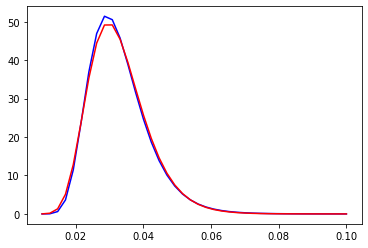

In [17]:
nu, beta, x0, y0, T = 1., 0.3, 0.02, 0.8, 0.05
rr = np.linspace(1E-2, 0.1, 40)
density0 = [pp(r/(y0*y0), T, nu)/(y0*y0) for r in rr]
densityLN = [densityLNMatched(T, y0, nu, r) for r in rr]
plt.plot(rr, density0, 'b')
plt.plot(rr, densityLN, 'r')
plt.show()